In [ ]:
! pip install transformers 
! pip install timm 
! pip install datasets 
! pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from timm import create_model
from transformers import default_data_collator
from datasets import load_dataset, DatasetDict, load_from_disk

# Load the Dataset
1. There are three components of data:
  * Original Image: This image is in RGB format.
  * Label Image: This image is in grayscale format, with each pixel value ranging from 0 to 255. Most segmentation labeling tools categorize images into up to 256 categories. Each pixel value corresponds to a label category. We will provide more details on this when we review the data.
  * id2label: This is a mapping of IDs to label categories.
2. In our case the directory structure of dataset is like this: The images is jpg dataset with RGB format and labels is png dataset with png format
  

  ```
    -dataset
      |-train
        |-images
          |-1.jpg
          ...
        |-labels
          |-4.png
          ...
      |-test
        |-images
          |-1.jpg
          ...
        |-labels
          |-4.png
          ...
  ```
3. The following code loads the data and retrun as dataset class with following format:


    ```
    Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1708
    })
    ```
4. Each individual item of dataset looks like:


```
{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x485>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x485>}
```











```
    '''
    def load_images_and_labels(image_directory, label_directory):
      image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".jpg")])
      label_files = sorted([f for f in os.listdir(label_directory) if f.endswith(".png")])

      data = []

      for image_file in image_files:
          file_name, _ = os.path.splitext(image_file)
          label_file = f"{file_name}.png"

          if label_file in label_files:
              with Image.open(os.path.join(image_directory, image_file)) as im:
                  img = im.copy()

              with Image.open(os.path.join(label_directory, label_file)) as im:
                  lbl = im.convert("L").copy()

              data.append({"pixel_values": img, "label": lbl})

      return data
      '''```



In [ ]:
import os
from PIL import Image
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor


def process_image(image_file, image_directory, label_directory):
    file_name, _ = os.path.splitext(image_file)
    label_file = f"{file_name}.png"

    with Image.open(os.path.join(image_directory, image_file)) as im:
        img = im.copy()

    with Image.open(os.path.join(label_directory, label_file)) as im:
        lbl = im.convert("L").copy()

    return {"pixel_values": img, "label": lbl}


def load_images_and_labels(image_directory, label_directory):
    image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".jpg")])
    label_files = sorted([f for f in os.listdir(label_directory) if f.endswith(".png")])

    data = []

    with ThreadPoolExecutor() as executor:
        results = executor.map(process_image, image_files, [image_directory]*len(image_files), [label_directory]*len(image_files))
        for result in results:
            data.append(result)

    return data


def create_image_segmentation_dataset(image_directory, label_directory):
      data = load_images_and_labels(image_directory, label_directory)
      dataset = Dataset.from_dict({"pixel_values": [item["pixel_values"] for item in data], "label": [item["label"] for item in data]})

      return dataset


In [ ]:
train_dataset=load_from_disk("/content/drive/MyDrive/Colab Notebooks/transformer_learn/chapter8/dataset/train_dataset.hf")
train_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 4983
})

## Let's review the data if it is in the correct format

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 4983
})

# Let's create train and test split

In [ ]:
train_test_split_ratio = 0.98
train_size = int(train_test_split_ratio * len(train_dataset))
test_size = len(train_dataset) - train_size
split_ds = train_dataset.train_test_split(train_size=train_size, test_size=test_size, seed=42)
final_ds = DatasetDict({"train": split_ds["train"], "test": split_ds["test"]})
train_ds=split_ds["train"]
test_ds=split_ds["test"]



# Let's create dictionary that maps between the category ID and Category Name

In [ ]:
id2label = {}

with open(base_dir+"category_id.txt", "r") as file:
    for line in file:
        id_, label = line.strip().split("\t")
        id2label[int(id_)] = label
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [ ]:
print(id2label)
print(label2id)

{0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice cream', 9: 'cheese butter', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red beans', 19: 'cashew', 20: 'dried cranberries', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken duck', 49: 'sausage', 50: 'fried meat', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: ' hanamaki baozi', 63: 'wonton dumplings', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu', 

# Plot the image and label

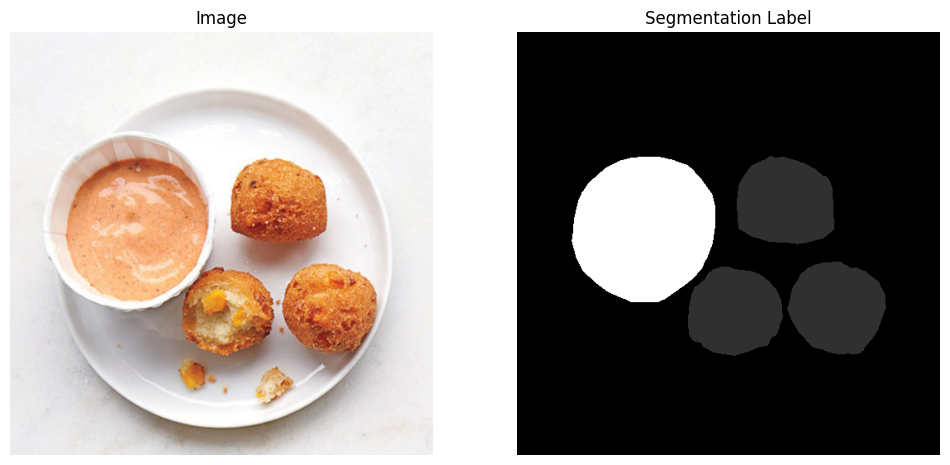

In [ ]:
import matplotlib.pyplot as plt

data=train_ds[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(data['pixel_values'])
ax1.set_title("Image")
ax1.axis("off")

ax2.imshow(data['label'], cmap="gray")
ax2.set_title("Segmentation Label")
ax2.axis("off")
# Unique categories in the image: [ 0 48 84 85 87]

plt.show()

### Unique pixel values on Label


In [ ]:
label=train_ds[0]['label']
import numpy as np
r_channel_array = np.array(label)

# Find the unique category IDs in the Red channel
unique_categories = np.unique(r_channel_array)

print("Unique categories in the image:", unique_categories)

Unique categories in the image: [ 0 10 52]


### Analysis:
1. The unique pixel values on our above label image are: [ 0, 10, 52]
2. From id2Labels dictionary: {0: 'background', 10: 'cake', 52: 'sauce'}
3. If we recall our earlier statement "Each pixel value corresponds to a label category". This seems to be correct.


# Transformation
1. jitter: The ColorJitter class applies random adjustments to an image's color properties
2. feature_extractor[SegformerFeatureExtractor]: Pre-process the image and segmentation map
  * it is the class to process the image and label for the Segformer model
  * it resizes the image
  * convert image into tensor
  * normalize the image 
  * one-hot encode the label

In [ ]:
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, Compose
from transformers import SegformerFeatureExtractor
from torchvision.transforms import ColorJitter


feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

#
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
# Let's Declare the Model

In [ ]:
from transformers import SegformerForSemanticSegmentation

model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch

# let's Create the training arguments

In [ ]:
from transformers import TrainingArguments

epochs = 10
lr = 3e-5 
batch_size = 4

training_args = TrainingArguments(
    '/content/drive/MyDrive/Colab Notebooks/transformer_learn/chapter8/run_may8',  # Change the output directory
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=5,  
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=10000,  
    eval_steps=1000,  
    logging_steps=500, 
    eval_accumulation_steps=10,  
    load_best_model_at_end=True,
)


Let's create function to calculate the evaluation metrics. This is what we are doing.
We are using IOU


```
IoU = (Intersection of predicted mask and ground truth mask) / (Union of predicted mask and ground truth mask)
```
* IOU equal to 1 signifies the predicted mask and the ground truth mask are identical,
* IOU equal to where 0 indicates no overlap between the predicted mask and the ground truth mask, 

1. The input to the calculate_segmentation_metrics function is a tuple containing the predicted logits and the ground truth labels.
2. As the predicted logits may have a lower spatial resolution than the ground truth labels, we need to resize the logits to match the size of the ground truth. We use bilinear interpolation for resizing the logits.
3. we take the argmax operation along the channel dimension to obtain the predicted labels.
4. After converting the predicted labels to a NumPy array, we compute the mean IoU metric using the iou_metric._compute() function. This function compares the predicted labels to the ground truth labels and calculates the IoU for each class.
5. The iou_metric._compute() function returns a dictionary containing the overall mean IoU, per-category accuracy, and per-category IoU.

In [ ]:
import evaluate
import torch
from torch import nn

iou_metric = evaluate.load("mean_iou")

def calculate_segmentation_metrics(prediction_ground_truth):
    with torch.no_grad():
        logits, ground_truth = prediction_ground_truth
        logits_as_tensor = torch.from_numpy(logits)

        # When training a segmentation model, the output( logits) has a lower spatial resolution compared 
        # to the ground truth labels. 
        #  We need to resize the logits to match the size of the ground_truth
        # 
        resized_logits = nn.functional.interpolate(
            logits_as_tensor,
            size=ground_truth.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        # need to convert to cpu before converting to numpy
        predicted_labels = resized_logits.detach().cpu().numpy()

        # Compute the mean IoU metric
        segmentation_metrics = iou_metric._compute(
            predictions=predicted_labels,
            references=ground_truth,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

        # Extract per-category metrics as individual key-value pairs
        category_accuracy = segmentation_metrics.pop("per_category_accuracy").tolist()
        category_iou = segmentation_metrics.pop("per_category_iou").tolist()

        # Update the metrics dictionary with per-category accuracies and IoUs
        segmentation_metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(category_accuracy)})
        segmentation_metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(category_iou)})

    return segmentation_metrics


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=calculate_segmentation_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Candy,Accuracy Egg tart,Accuracy French fries,Accuracy Chocolate,Accuracy Biscuit,Accuracy Popcorn,Accuracy Pudding,Accuracy Ice cream,Accuracy Cheese butter,Accuracy Cake,Accuracy Wine,Accuracy Milkshake,Accuracy Coffee,Accuracy Juice,Accuracy Milk,Accuracy Tea,Accuracy Almond,Accuracy Red beans,Accuracy Cashew,Accuracy Dried cranberries,Accuracy Soy,Accuracy Walnut,Accuracy Peanut,Accuracy Egg,Accuracy Apple,Accuracy Date,Accuracy Apricot,Accuracy Avocado,Accuracy Banana,Accuracy Strawberry,Accuracy Cherry,Accuracy Blueberry,Accuracy Raspberry,Accuracy Mango,Accuracy Olives,Accuracy Peach,Accuracy Lemon,Accuracy Pear,Accuracy Fig,Accuracy Pineapple,Accuracy Grape,Accuracy Kiwi,Accuracy Melon,Accuracy Orange,Accuracy Watermelon,Accuracy Steak,Accuracy Pork,Accuracy Chicken duck,Accuracy Sausage,Accuracy Fried meat,Accuracy Lamb,Accuracy Sauce,Accuracy Crab,Accuracy Fish,Accuracy Shellfish,Accuracy Shrimp,Accuracy Soup,Accuracy Bread,Accuracy Corn,Accuracy Hamburg,Accuracy Pizza,Accuracy hanamaki baozi,Accuracy Wonton dumplings,Accuracy Pasta,Accuracy Noodles,Accuracy Rice,Accuracy Pie,Accuracy Tofu,Accuracy Eggplant,Accuracy Potato,Accuracy Garlic,Accuracy Cauliflower,Accuracy Tomato,Accuracy Kelp,Accuracy Seaweed,Accuracy Spring onion,Accuracy Rape,Accuracy Ginger,Accuracy Okra,Accuracy Lettuce,Accuracy Pumpkin,Accuracy Cucumber,Accuracy White radish,Accuracy Carrot,Accuracy Asparagus,Accuracy Bamboo shoots,Accuracy Broccoli,Accuracy Celery stick,Accuracy Cilantro mint,Accuracy Snow peas,Accuracy cabbage,Accuracy Bean sprouts,Accuracy Onion,Accuracy Pepper,Accuracy Green beans,Accuracy French beans,Accuracy King oyster mushroom,Accuracy Shiitake,Accuracy Enoki mushroom,Accuracy Oyster mushroom,Accuracy White button mushroom,Accuracy Salad,Accuracy Other ingredients,Iou Background,Iou Candy,Iou Egg tart,Iou French fries,Iou Chocolate,Iou Biscuit,Iou Popcorn,Iou Pudding,Iou Ice cream,Iou Cheese butter,Iou Cake,Iou Wine,Iou Milkshake,Iou Coffee,Iou Juice,Iou Milk,Iou Tea,Iou Almond,Iou Red beans,Iou Cashew,Iou Dried cranberries,Iou Soy,Iou Walnut,Iou Peanut,Iou Egg,Iou Apple,Iou Date,Iou Apricot,Iou Avocado,Iou Banana,Iou Strawberry,Iou Cherry,Iou Blueberry,Iou Raspberry,Iou Mango,Iou Olives,Iou Peach,Iou Lemon,Iou Pear,Iou Fig,Iou Pineapple,Iou Grape,Iou Kiwi,Iou Melon,Iou Orange,Iou Watermelon,Iou Steak,Iou Pork,Iou Chicken duck,Iou Sausage,Iou Fried meat,Iou Lamb,Iou Sauce,Iou Crab,Iou Fish,Iou Shellfish,Iou Shrimp,Iou Soup,Iou Bread,Iou Corn,Iou Hamburg,Iou Pizza,Iou hanamaki baozi,Iou Wonton dumplings,Iou Pasta,Iou Noodles,Iou Rice,Iou Pie,Iou Tofu,Iou Eggplant,Iou Potato,Iou Garlic,Iou Cauliflower,Iou Tomato,Iou Kelp,Iou Seaweed,Iou Spring onion,Iou Rape,Iou Ginger,Iou Okra,Iou Lettuce,Iou Pumpkin,Iou Cucumber,Iou White radish,Iou Carrot,Iou Asparagus,Iou Bamboo shoots,Iou Broccoli,Iou Celery stick,Iou Cilantro mint,Iou Snow peas,Iou cabbage,Iou Bean sprouts,Iou Onion,Iou Pepper,Iou Green beans,Iou French beans,Iou King oyster mushroom,Iou Shiitake,Iou Enoki mushroom,Iou Oyster mushroom,Iou White button mushroom,Iou Salad,Iou Other ingredients
1000,2.246000,1.901479,0.042073,0.087406,0.247718,nan,0.000000,nan,0.000000,nan,0.000000,nan,nan,0.161644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan,0.000000,0.000000,nan,0.000000,nan,nan,nan,0.000000,nan,nan,nan,0.000000,0.000000,0.352884,0.000000,0.000000,nan,0.000000,nan,0.000000,0.000000,nan,0.000000,0.000000,nan,nan,nan,0.000000,0.000000,0.337469,0.000172,0.558098,0.000000,0.000000,0.000000,0.001694,nan,0.000000,0.000000,0.000000,0.000000,0.762430,0.916713,nan,nan,0.000000,nan,0.000000,0.134066,0.162190,0.000000,0.000000,nan,0.346869,0.000000,0.000000,0.312997,nan,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000875,0.000000,0.872837,nan,nan,0.912206,0.000000,0.110465,nan,nan,nan,0.000000,0.000000,0.000000,0.000000,nan,0.000000,nan,nan,0.00000

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: inval

TrainOutput(global_step=12210, training_loss=1.4155310690939964, metrics={'train_runtime': 9622.5693, 'train_samples_per_second': 5.075, 'train_steps_per_second': 1.269, 'total_flos': 8.619300056412979e+17, 'train_loss': 1.4155310690939964, 'epoch': 10.0})

In [ ]:
save_directory = '/content/drive/MyDrive/Colab Notebooks/transformer_learn/chapter8/model/'
model.save_pretrained(save_directory)

In [ ]:
load_directory = save_directory

loaded_model = SegformerForSemanticSegmentation.from_pretrained(
    load_directory,
    id2label=id2label,
    label2id=label2id
)

# Let's Use the Model for Inference.

In [ ]:
# 

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


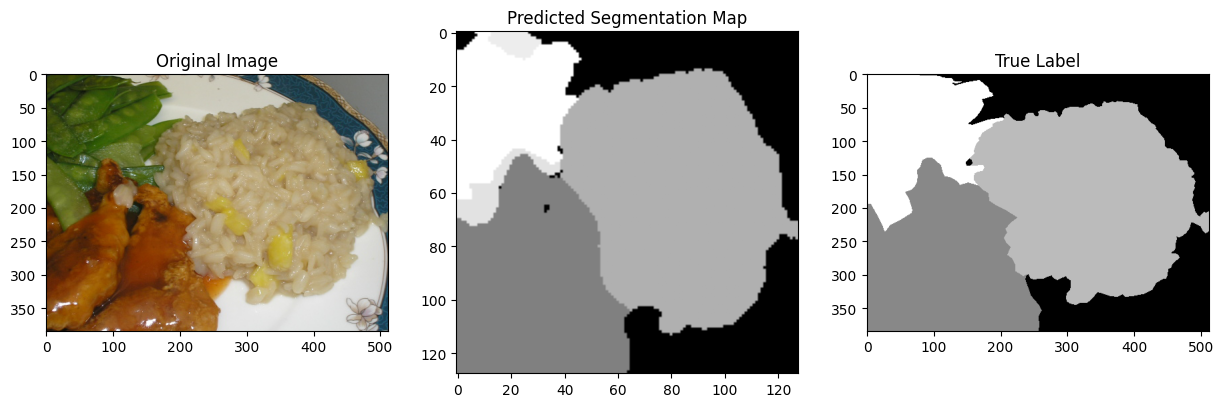

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from transformers import SegformerFeatureExtractor
from matplotlib import pyplot as plt

# Load the feature extractor
feature_extractor = SegformerFeatureExtractor()

# Load the input image (replace 'input_image_path' with the path to your image)
image = Image.open('/content/drive/MyDrive/Colab Notebooks/transformer_learn/chapter8/dataset/train/images/00000000.jpg').convert("RGB")

# Preprocess the input image
inputs = feature_extractor(images=[image], return_tensors="pt")

# Get the segmentation predictions
with torch.no_grad():
    outputs = loaded_model(**inputs)
    predictions = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

# Create a grayscale color map from the predicted segmentation map using the id2label mapping
grayscale_map = np.zeros((predictions.shape[0], predictions.shape[1]), dtype=np.uint8)
for label_id in id2label.keys():
    grayscale_map[predictions == label_id] = label_id

# Convert the grayscale map to a PIL image
segmentation_image = Image.fromarray(grayscale_map, mode='L')

# Load the true label image
true_label_path = '/content/drive/MyDrive/Colab Notebooks/transformer_learn/chapter8/dataset/train/labels/00000000.png'
true_label = Image.open(true_label_path).convert("L")

# Plot the original image, predicted segmentation map, and true label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image)
ax1.set_title("Original Image")
ax2.imshow(segmentation_image, cmap='gray')
ax2.set_title("Predicted Segmentation Map")
ax3.imshow(true_label, cmap='gray')
ax3.set_title("True Label")
plt.show()


# Let's Upload the model to the HuggingFace

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
loaded_model.push_to_hub("segformer-b0-finetuned-food")

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/prem-timsina/segformer-b0-finetuned-food/commit/3acb8201c4ca5632a5c77b51895c9f045c217c52', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='3acb8201c4ca5632a5c77b51895c9f045c217c52', pr_url=None, pr_revision=None, pr_num=None)